In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core.base import Constraint as pyo_constraint
from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [2]:
def load_input_data(input_data):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_facilities = int(firstLine[0])
    num_customers = int(firstLine[1])
    
    data_dict = {}

    facility_cost_array = np.zeros(num_facilities)
    facility_capacity_array = np.zeros(num_facilities)
    facility_location_array = np.zeros((num_facilities, 2))
    for i in range(num_facilities):
        line = lines[i + 1]
        parts = line.split()
        facility_cost_array[i] = parts[0]
        facility_capacity_array[i] = parts[1]
        facility_location_array[i,:] = np.array([parts[2], parts[3]])
        
    data_dict['facility_cost_array'] = facility_cost_array
    data_dict['facility_capacity_array'] = facility_capacity_array
    data_dict['facility_location_array'] = facility_location_array

    customer_demand_array = np.zeros(num_customers)
    customer_location_array = np.zeros((num_customers, 2))
    for i in range(num_customers):
        line = lines[i + 1 + num_facilities]
        parts = line.split()
        customer_demand_array[i] = parts[0]
        customer_location_array[i,:] = np.array([parts[1], parts[2]])
        
    data_dict['customer_demand_array'] = customer_demand_array
    data_dict['customer_location_array'] = customer_location_array
    
    return data_dict

In [3]:
input_file = open('data/fl_500_7','r').read()

In [4]:
data_dict = load_input_data(input_file)

In [37]:
data_dict

{'facility_cost_array': array([100., 100., 100.]),
 'facility_capacity_array': array([100., 100., 500.]),
 'facility_location_array': array([[1065., 1065.],
        [1062., 1062.],
        [   0.,    0.]]),
 'customer_demand_array': array([50., 50., 75., 75.]),
 'customer_location_array': array([[1397., 1397.],
        [1398., 1398.],
        [1399., 1399.],
        [ 586.,  586.]])}

In [5]:
len(data_dict['facility_cost_array'])

500

In [5]:
def prepare_output_data(data_dict, results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    solution = np.zeros(len(data_dict['customer_location_array']))
    for facility, customer_list in results_dict['facility_customers'].items():
        solution[customer_list] = facility
        
    
    output_data = str(results_dict['objective_value']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution.astype(int)))
    
    return output_data

In [152]:
prepare_output_data(data_dict, results_dict, is_provably_optimal=False)

In [6]:
def create_facility_customer_dist_matrix(data_dict):
    
    """
    Distance matrix between facilities (rows) and customers (columns)
    """
    
    return cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])

In [25]:
facility_customer_dist_matrix = cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

### Write a greedy algorithm to solve

In [19]:
def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    """
    Greedy algorithm. Simply finds the customer closest to any facility with enough
    capacity and assigns them to that facility, then moves to the next closest, etc. 
    """
    
    def get_k_smallest_indicies(arr, k):
        
        """Helper function"""
    
        flat_indices = np.argpartition(arr.ravel(), k-1)[:k]
        row_indices, col_indices = np.unravel_index(flat_indices, arr.shape)
        min_elements = arr[row_indices, col_indices]
        min_elements_order = np.argsort(min_elements)
        row_indices, col_indices = row_indices[min_elements_order], col_indices[min_elements_order]

        return [[row_indices[i], col_indices[i]] for i in range(len(col_indices))]
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix_copy = create_facility_customer_dist_matrix(data_dict)
    else:
        facility_customer_dist_matrix_copy = facility_customer_dist_matrix.copy()
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    customers_not_used = np.arange(num_customers)
    mins_to_choose_add = 5
    mins_to_choose = 5
    while len(customers_not_used) > 0:
        print(customers_not_used)
        customer_fits = False
        #facility_customer_dist_matrix_copy = facility_customer_dist_matrix_copy[:, customers_not_used]
        counter = 0
        while not customer_fits:
            if counter > mins_to_choose-1:
                mins_to_choose += mins_to_choose_add
            smallest_indicies = get_k_smallest_indicies(facility_customer_dist_matrix_copy[:, customers_not_used], 
                                                        min(mins_to_choose, 
                                                            facility_customer_dist_matrix_copy[:, customers_not_used].size-1))
            #print(smallest_indicies)
            #print(counter)
            #print(mins_to_choose)
            facility, customer = smallest_indicies[counter][0], smallest_indicies[counter][1]
            cost = facility_customer_dist_matrix_copy[:, customers_not_used][facility, customer]
            demand = customer_demand_array[customer]
            #print(cost)
            if facility_remaining_capacity[facility] >= demand:
                facility_remaining_capacity[facility] -= demand
                transport_costs += cost
                if facility not in facility_customers.keys():
                    facility_customers[facility] = [customer]
                    fixed_costs += facility_cost_array[facility]
                else:
                    facility_customers[facility].append(customer)
                customers_not_used = customers_not_used[customers_not_used!=customer]
                customer_fits = True
            else:
                counter += 1
            
    return facility_customers
            
            
        

In [26]:
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

In [59]:
def greedy_solution(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    
    customer_ordering = np.argsort(np.min(facility_customer_dist_matrix, axis=0))
    
    for customer in customer_ordering:
        closest_facility_indexes = np.argsort(facility_customer_dist_matrix[:, customer])
        customer_demand = customer_demand_array[customer]
        customer_allocated = False
        counter = 0
        #print('customer: ' + str(customer))
        #print('customer_demand: ' + str(customer_demand))
        while not customer_allocated:
            facility = closest_facility_indexes[counter]
            #print('facility: ' + str(facility))
            #print('facility capacity: ' +str(facility_remaining_capacity[facility]))
            if facility in facility_customers.keys():
                if facility_remaining_capacity[facility] >= customer_demand:
                    facility_customers[facility].append(customer)
                    facility_remaining_capacity[facility] -= customer_demand
                    transport_costs += facility_customer_dist_matrix[facility, customer]
                    customer_allocated = True
                    #print('used facility ' + str(facility))
                else:
                    counter += 1
            else:
                facility_customers[facility] = [customer]
                facility_remaining_capacity[facility] -= customer_demand
                fixed_costs += facility_cost_array[facility]
                transport_costs += facility_customer_dist_matrix[facility, customer]
                customer_allocated = True
                #print('used facility ' + str(facility))
        #print(' ')
        
    out_dict = {}
    out_dict['facility_customers'] = facility_customers
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = False
        
    return out_dict
                

In [81]:
results_dict = greedy_solution(data_dict)
results_dict

{'facility_customers': {113: [304, 490],
  162: [656, 98, 71, 518],
  118: [75, 243, 725, 27, 105, 332, 164],
  173: [209, 465, 545, 763, 660],
  27: [181, 422, 416, 535, 471, 167, 758, 693],
  26: [316, 676, 784, 459, 313, 634, 63, 195, 473],
  104: [464, 203],
  172: [258, 594, 764, 499],
  87: [658, 378, 375],
  95: [179, 519, 627, 26],
  76: [743, 400],
  82: [73],
  120: [113, 548, 311, 331, 431, 38],
  190: [318, 791, 458, 774, 408],
  46: [474, 307, 682, 104],
  60: [742, 737, 449, 193, 740, 74, 681, 141, 20, 549, 182, 228],
  149: [510, 585, 102, 642],
  146: [598, 497],
  58: [120, 294],
  49: [138, 41, 174, 649, 194],
  116: [762, 330, 6, 324, 289, 382, 367, 219],
  33: [117, 95, 5, 781, 626],
  164: [277],
  160: [58, 234, 602, 152, 551, 281, 633, 463, 714],
  91: [123, 356],
  108: [567, 101, 358, 619, 280, 616, 618, 217],
  57: [447, 709, 678],
  98: [136, 724, 623],
  32: [175, 145, 165, 232, 778, 703, 218, 226, 630],
  34: [733, 112, 461, 739, 372, 436, 700, 579],
  51: 

### Write and solve the optimisation model with Pyomo and CBC

In [8]:
def objective_function(model):
    
    return sum(model.fixed_costs[f] * model.x[f] for f in model.F) \
         + sum(sum(model.transport_costs[f, c] * model.y[f, c] for f in model.F) for c in model.C)

In [9]:
def constraint_open_facilities(model, f, c):
    
    return model.y[f, c] <= model.x[f]

def constraint_customer_assigned(model, c):
    
    return sum(model.y[f, c] for f in model.F) == 1

def constraint_capacity(model, f):
    
    return sum(model.demands[c] * model.y[f, c] for c in model.C) <= model.capacities[f]

In [10]:
def build_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in range(len(facility_cost_array))])
    model.C = pyo.Set(initialize=[c for c in range(len(customer_demand_array))])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={counter: element for counter, element in 
                                              enumerate(facility_cost_array)}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(counter_1, counter_2): facility_customer_dist_matrix[counter_1, counter_2] 
                                                  for counter_1 in range(len(facility_cost_array))
                                                  for counter_2 in range(len(customer_demand_array))}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={counter: element for counter, element in 
                                          enumerate(customer_demand_array)}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={counter: element for counter, element in 
                                             enumerate(facility_capacity_array)}, default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [11]:
def solve_model_milp(model, solver_name, solver_path, timeout_time=120, ratio_gap=0.01, show_working=True):
    
    print('Run start time: ' + str(ctime()))
    
    # Use CPLEX on the NEOS server
    if solver_name == 'cplex':
        manager = pyo.SolverManagerFactory('neos')
        opt_settings = SolverFactory(solver_name)
        opt_settings.set_options('mipgap=' + str(ratio_gap))
        opt_settings.set_options('timelimit=' + str(timeout_time))
        opt_settings.set_options('mipdisplay=' + str(3))
        opt_settings.set_options('nodefile=' + str(2))
        opt_settings.set_options('treememory=' + str(10000))
        results = manager.solve(model, opt=opt_settings, keepfiles=True)
        
    elif solver_name == 'cbc':
        opt_settings = SolverFactory(solver_name, executable=solver_path)
        opt_settings.set_options('sec=' + str(timeout_time))
        opt_settings.set_options('ratioGap=' + str(ratio_gap))
        results = opt_settings.solve(model, tee=show_working)
        
    else:
        raise ValueError(f'Solver {solver_name} not supported')
        
    print('Run finish time: ' + str(ctime()))        
    
    return model, results

In [88]:
model_instance = build_model(data_dict)

In [65]:
model_instance, results_instance = solve_model_milp(model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=300, ratio_gap=0, show_working=True)

Run start time: Sat Feb  1 23:26:24 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 300 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmp7d2k5wx9.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmp7d2k5wx9.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 300
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 1250 (-76) rows, 1274 (-2) columns and 3650 (-1351) elements
Statistics for presolved model
Original problem has 1275 integers (1275 of which binary)
Presolved problem has 1274 integers (1274 of which binary)
==== 0 zero objective 1251 different
==== absolute objective values 1251 different
==== for integers 0 zero objective 1251 different
==== for integers absolute objective values 1251 different
===== end objective counts


Problem has 1250 rows,

In [ ]:
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=300, ratio_gap=0, show_working=True)

Run start time: Sun Feb  2 00:00:15 2020


In [43]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
        
    return out_dict

In [85]:
results_dict = get_results_dict(model_instance, results_instance, data_dict)
results_dict

{'facility_customers': {0: [1, 124, 154, 295, 380, 394, 424, 508, 635, 789],
  2: [88, 233, 287, 556, 583, 666, 714],
  3: [34, 57, 62, 147, 349, 443, 498, 533, 615, 632],
  4: [52, 133, 149, 216, 276, 628, 710, 726],
  6: [8, 128, 131, 237, 442, 566, 625],
  7: [262, 445, 452, 462, 525, 537, 622, 674, 767],
  9: [25, 47, 167, 181, 202, 261, 422, 529, 535, 732],
  18: [51, 70, 90, 139, 310, 450],
  19: [11, 208, 278, 350, 456, 530, 679, 715, 718],
  22: [157, 176, 335, 341, 466, 478, 516, 523, 796],
  25: [66, 67, 213, 336, 362, 476, 477],
  26: [63, 191, 195, 313, 316, 459, 473, 634, 676, 784],
  28: [35, 114, 212, 223, 265, 320, 590, 727, 746],
  30: [49, 79, 91, 115, 269, 338, 493, 687, 751],
  32: [121, 145, 160, 165, 175, 232, 575, 703, 778],
  33: [5, 95, 117, 624, 626, 781, 786],
  34: [112, 225, 281, 372, 461, 463, 573, 579, 700, 733, 739],
  35: [12, 18, 45, 196, 253, 339, 359, 404, 668],
  37: [65, 84, 120, 245, 294, 453, 692, 758],
  45: [178, 251, 254, 285, 403, 512, 514, 5

In [84]:
results_dict

{'facility_customers': {113: [304, 490],
  162: [656, 98, 71, 518],
  118: [75, 243, 725, 27, 105, 332, 164],
  173: [209, 465, 545, 763, 660],
  27: [181, 422, 416, 535, 471, 167, 758, 693],
  26: [316, 676, 784, 459, 313, 634, 63, 195, 473],
  104: [464, 203],
  172: [258, 594, 764, 499],
  87: [658, 378, 375],
  95: [179, 519, 627, 26],
  76: [743, 400],
  82: [73],
  120: [113, 548, 311, 331, 431, 38],
  190: [318, 791, 458, 774, 408],
  46: [474, 307, 682, 104],
  60: [742, 737, 449, 193, 740, 74, 681, 141, 20, 549, 182, 228],
  149: [510, 585, 102, 642],
  146: [598, 497],
  58: [120, 294],
  49: [138, 41, 174, 649, 194],
  116: [762, 330, 6, 324, 289, 382, 367, 219],
  33: [117, 95, 5, 781, 626],
  164: [277],
  160: [58, 234, 602, 152, 551, 281, 633, 463, 714],
  91: [123, 356],
  108: [567, 101, 358, 619, 280, 616, 618, 217],
  57: [447, 709, 678],
  98: [136, 724, 623],
  32: [175, 145, 165, 232, 778, 703, 218, 226, 630],
  34: [733, 112, 461, 739, 372, 436, 700, 579],
  51: 

In [71]:
def visualise_solution(data_dict, results_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Fixed cost: ' + str(int(results_dict['fixed_costs'])) \
                 + '   Transport costs: ' + str(int(results_dict['transport_costs'])))
    ax.scatter(customer_location_array[:, 0], customer_location_array[:, 1],  marker='+')
    ax.scatter(facility_location_array[:, 0], facility_location_array[:, 1],  marker='H')
    ax.axis('equal')
    
    for facility in range(len(facility_cost_array)):
        facility_location = facility_location_array[facility]
        if facility in results_dict['facility_customers']:
            for customer in results_dict['facility_customers'][facility]:
                customer_location = customer_location_array[customer]
                ax.annotate("",
                            xy=facility_location, xycoords='data',
                            xytext=customer_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


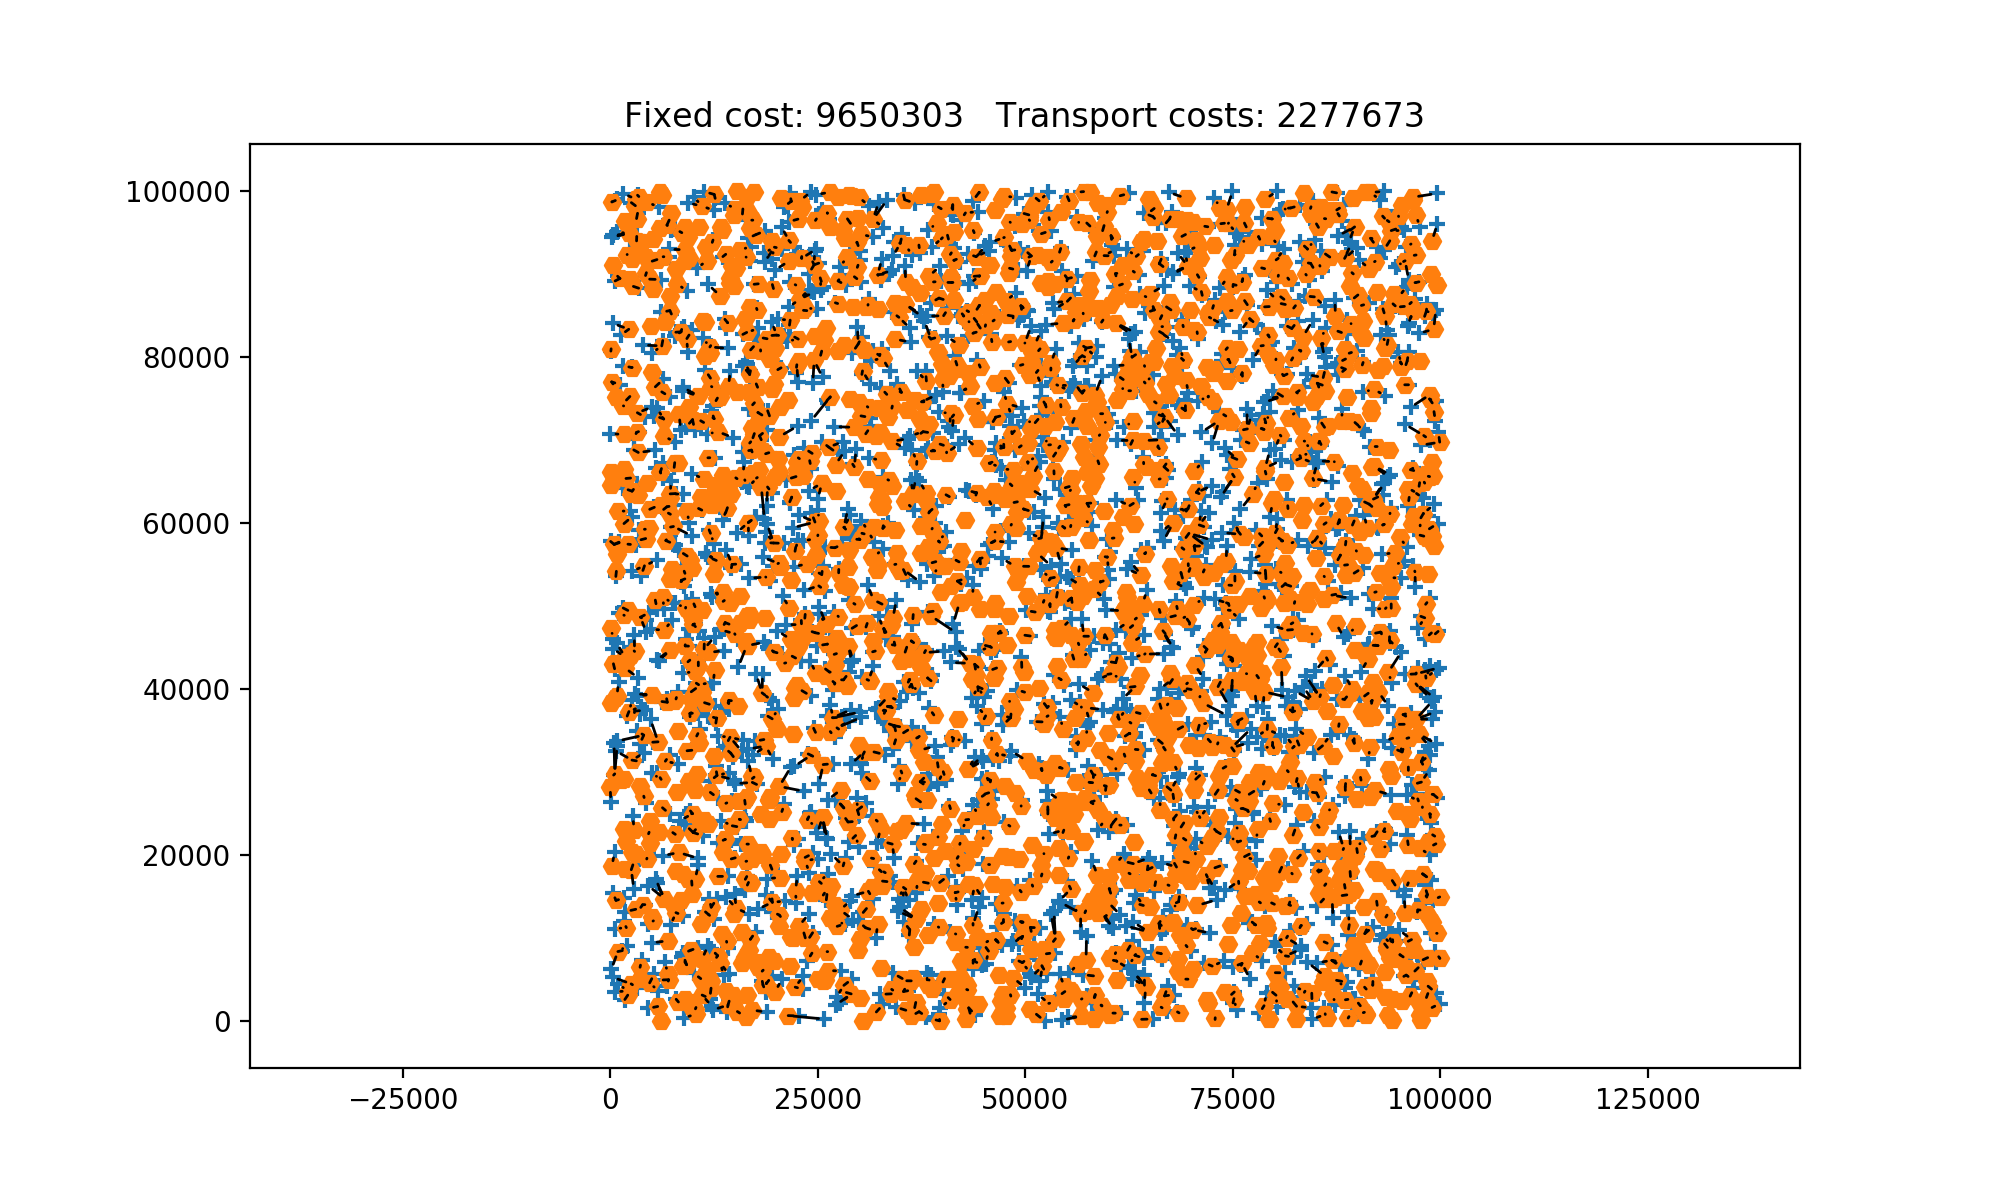

In [72]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)